In [115]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [116]:
lstm_error = dict()

In [117]:
def error_metrics(y_pred, y_observed, model_name = None, test = True):
    
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()

    if isinstance(y_observed, np.ndarray):
        y_observed = y_observed
    else:
        y_observed = y_observed.to_numpy()

    print(f'Error metrics for {model_name} \n')

    RMSE = np.sqrt(mean_squared_error(y_observed, y_pred))
    print(f'Root Mean Squared Error (RMSE): {round(RMSE, 3)}')

    MAE = mean_absolute_error(y_observed, y_pred)
    print(f'Mean Absolute Error (MAE): {round(MAE, 3)}')

    MAPE = (np.mean(np.abs((y_observed - y_pred) / y_observed)) * 100)
    print(f'Mean Absolute Percentage Error (MAPE): {round(MAPE, 3)} %')

    R2 = r2_score(y_observed, y_pred)
    print(f'Variance Score (R2): {round(R2, 3)}')

    if test:
        train_test = 'test'
    else:
        train_test = 'train'

    names = ['model', 'train_test', 'RMSE', 'MAE', 'MAPE', 'R2']
    values = [model_name, train_test, RMSE, MAE, MAPE, R2]
    list_error = list(zip(names, values))

    for error in list_error:
        if error[0] in lstm_error:
            lstm_error[error[0]].append(error[1])
        else:
            lstm_error[error[0]] = [error[1]]

In [118]:
# creating function for plotting predicted vs actual energy values
def PredTrueReg(pred, truth, model_name=None):
    """
    Plots the observed energy consumption against the predicted energy consumption
    """
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.scatter(truth, pred, alpha=0.7) 
    plt.xlabel("Observed Electric Consumption (MwH)")
    plt.ylabel("Predicted Electric Consumption (MwH)")
    plt.title(f"Observed VS Predicted Electric Consumption using {model_name}", fontsize=14)

    #plotting 45 deg line to see how the prediction differs from the observed values
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color='black')

In [119]:
def PlotPredictedTS(observed_ts, predicted_ts, model_name=None, observed_alpha = 0.5, predicted_alpha = 0.7):
    
    plt.figure(figsize=(16, 9))
    sns.lineplot(x= observed_ts.index, y=np.array(observed_ts.values), color='red', alpha=observed_alpha, label='Observed')
    sns.lineplot(x= observed_ts.index, y=predicted_ts, color='lightslategrey', alpha=predicted_alpha, label='Predicted')
    plt.title(f'Observed VS Predicted Energy Consumption using {model_name}')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MwH)')

    plt.show()

In [120]:
def TrainTestSplit(data, test_size = 0.15, scale = False, cols_to_transform=None, include_test_scale=False):
    
    df = data.copy()
    # get the index after which test set starts
    test_index = int(len(df)*(1-test_size))
    
    # StandardScaler fit on the entire dataset
    if scale and include_test_scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('demand', axis = 1).iloc[:test_index]
    y_train = df.demand.iloc[:test_index]
    X_test = df.drop('demand', axis = 1).iloc[test_index:]
    y_test = df.demand.iloc[test_index:]
    
    # StandardScaler fit only on the training set
    if scale and not include_test_scale:
        scaler = StandardScaler()
        X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
        X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])
    
    return X_train, X_test, y_train, y_test

In [122]:
# Importing the dataset
df = pd.read_csv('./Data/cleandata/CleanedCT.csv', parse_dates=['ts'], index_col='ts')
df = df.drop(['Unnamed: 0'], axis=1)
df['non_working'] = df.apply(lambda x: True if \
                                         ((x['non_working'] == 'non-working'))
                                         else False, axis = 1)
print('Data Frame Shape:', df.shape)
df.head()

Data Frame Shape: (113976, 14)


,zone,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,day_of_year,weekend,holiday,trend,non_working
ts,,,,,,,,,,,,,,
2004-01-01 00:00:00,CT,3126.0,33.0,26.0,2004-01-01,2004,1,0,Thu,1,False,True,7344.0,True
2004-01-01 01:00:00,CT,2945.0,34.0,26.0,2004-01-01,2004,1,1,Thu,1,False,True,7345.0,True
2004-01-01 02:00:00,CT,2804.0,40.0,26.0,2004-01-01,2004,1,2,Thu,1,False,True,7346.0,True
2004-01-01 03:00:00,CT,2729.0,38.0,23.0,2004-01-01,2004,1,3,Thu,1,False,True,7347.0,True
2004-01-01 04:00:00,CT,2722.0,37.0,21.0,2004-01-01,2004,1,4,Thu,1,False,True,7348.0,True


In [123]:
df['day_of_month'] = df.index.day
df['day_of_week (Num)'] = df.index.dayofweek
df['non_working'] = df.apply(lambda x: 1 if \
                                         ((x['holiday'] == True) or (x['day_of_week'] in ['Sat', 'Sun']))
                                         else 0, axis = 1)

In [124]:
# Dropping extra columns

df = df.drop('date', axis=1)
df = df.drop('day_of_week', axis=1)
df = df.drop('holiday', axis=1)
df = df.drop('weekend', axis=1)
df = df.drop('trend', axis=1)
df = df.drop('zone', axis=1)
df.head()

,demand,drybulb,dewpnt,year,month,hour,day_of_year,non_working,day_of_month,day_of_week (Num)
ts,,,,,,,,,,
2004-01-01 00:00:00,3126.0,33.0,26.0,2004,1,0,1,1,1,3
2004-01-01 01:00:00,2945.0,34.0,26.0,2004,1,1,1,1,1,3
2004-01-01 02:00:00,2804.0,40.0,26.0,2004,1,2,1,1,1,3
2004-01-01 03:00:00,2729.0,38.0,23.0,2004,1,3,1,1,1,3
2004-01-01 04:00:00,2722.0,37.0,21.0,2004,1,4,1,1,1,3


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113976 entries, 2004-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   demand             113976 non-null  float64
 1   drybulb            113976 non-null  float64
 2   dewpnt             113976 non-null  float64
 3   year               113976 non-null  int64  
 4   month              113976 non-null  int64  
 5   hour               113976 non-null  int64  
 6   day_of_year        113976 non-null  int64  
 7   non_working        113976 non-null  int64  
 8   day_of_month       113976 non-null  int64  
 9   day_of_week (Num)  113976 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 9.6 MB


In [126]:
train_size = int(len(df) * 0.9)
test_size = int(len(df) - train_size)

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (102578, 10)
test shape: (11398, 10)


In [127]:
from sklearn.preprocessing import RobustScaler

f_columns = ['drybulb', 'dewpnt']

f_transformer = RobustScaler()
demand_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
demand_transformer = demand_transformer.fit(train[['demand']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['demand'] = demand_transformer.transform(train[['demand']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['demand'] = demand_transformer.transform(test[['demand']])

/Users/alnoaimi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-41e13b917e98>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['demand'] = demand_transformer.transform(train[['demand']])
/Users/alnoaimi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [128]:
df.head(2)

,demand,drybulb,dewpnt,year,month,hour,day_of_year,non_working,day_of_month,day_of_week (Num)
ts,,,,,,,,,,
2004-01-01 00:00:00,-0.506679,-0.612903,-0.4375,2004,1,0,1,1,1,3
2004-01-01 01:00:00,-0.679389,-0.580645,-0.4375,2004,1,1,1,1,1,3


In [129]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [130]:
TIME_STEPS = 24

X_train, y_train = create_dataset(train, train.demand, time_steps=TIME_STEPS)
X_test, y_test = create_dataset(test, test.demand, time_steps=TIME_STEPS)

In [16]:
print(X_train.shape, y_train.shape)

(91156, 24, 10) (91156,)


In [131]:
## Testing
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

In [132]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [133]:
#%%LSTM Model
modelLSTM=Sequential()
modelLSTM.add(LSTM(120,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
modelLSTM.add(LSTM(80,return_sequences=True))
modelLSTM.add(LSTM(40))
modelLSTM.add(Dense(1))
modelLSTM.compile(loss='mean_squared_error',optimizer='adam')
modelLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 24, 120)           62880     
                                                                 
 lstm_7 (LSTM)               (None, 24, 80)            64320     
                                                                 
 lstm_8 (LSTM)               (None, 40)                19360     
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 146,601
Trainable params: 146,601
Non-trainable params: 0
_________________________________________________________________


In [134]:
history = modelLSTM.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25
2885/2885 [==============================] - 122s 40ms/step - loss: 0.3010 - val_loss: 0.0672
Epoch 2/25
2885/2885 [==============================] - 101s 35ms/step - loss: 0.0228 - val_loss: 0.0135
Epoch 3/25
2885/2885 [==============================] - 100s 35ms/step - loss: 0.0129 - val_loss: 0.0091
Epoch 4/25
2885/2885 [==============================] - 105s 36ms/step - loss: 0.0104 - val_loss: 0.0058
Epoch 5/25
2885/2885 [==============================] - 103s 36ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 6/25
2885/2885 [==============================] - 96s 33ms/step - loss: 0.0068 - val_loss: 0.0041
Epoch 7/25
2885/2885 [==============================] - 106s 37ms/step - loss: 0.0069 - val_loss: 0.0169
Epoch 8/25
2885/2885 [==============================] - 99s 34ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 9/25
2885/2885 [==============================] - 102s 35ms/step - loss: 0.0051 - val_loss: 0.0027
Epoch 10/25
2885/2885 [==============================] - 

In [135]:
y_pred = modelLSTM.predict(X_test)

356/356 [==============================] - 8s 11ms/step


In [136]:
y_train_inv = demand_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = demand_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = demand_transformer.inverse_transform(y_pred)

In [137]:
y_pred_inv

array([[2226.2896],
       [2108.4263],
       [2130.0781],
       ...,
       [3250.4382],
       [3025.9553],
       [2780.4521]], dtype=float32)

In [138]:
y_test_inv = pd.DataFrame(y_test_inv[0], index=df.index[-len(y_test_inv[0]):])
y_test_inv = pd.Series(y_test_inv[0])
y_test_inv

ts
2015-09-15 02:00:00    2302.000
2015-09-15 03:00:00    2278.000
2015-09-15 04:00:00    2335.000
2015-09-15 05:00:00    2552.000
2015-09-15 06:00:00    2942.000
                         ...   
2016-12-31 19:00:00    3744.918
2016-12-31 20:00:00    3558.586
2016-12-31 21:00:00    3378.466
2016-12-31 22:00:00    3195.386
2016-12-31 23:00:00    3016.453
Name: 0, Length: 11374, dtype: float64

In [139]:
LSTM_pred = pd.DataFrame(y_pred_inv, index=df.index[-len(y_test):])
LSTM_pred = pd.Series(LSTM_pred[0])
LSTM_pred

ts
2015-09-15 02:00:00    2226.289551
2015-09-15 03:00:00    2108.426270
2015-09-15 04:00:00    2130.078125
2015-09-15 05:00:00    2347.734375
2015-09-15 06:00:00    2671.717041
                          ...     
2016-12-31 19:00:00    3665.876465
2016-12-31 20:00:00    3464.966553
2016-12-31 21:00:00    3250.438232
2016-12-31 22:00:00    3025.955322
2016-12-31 23:00:00    2780.452148
Name: 0, Length: 11374, dtype: float32

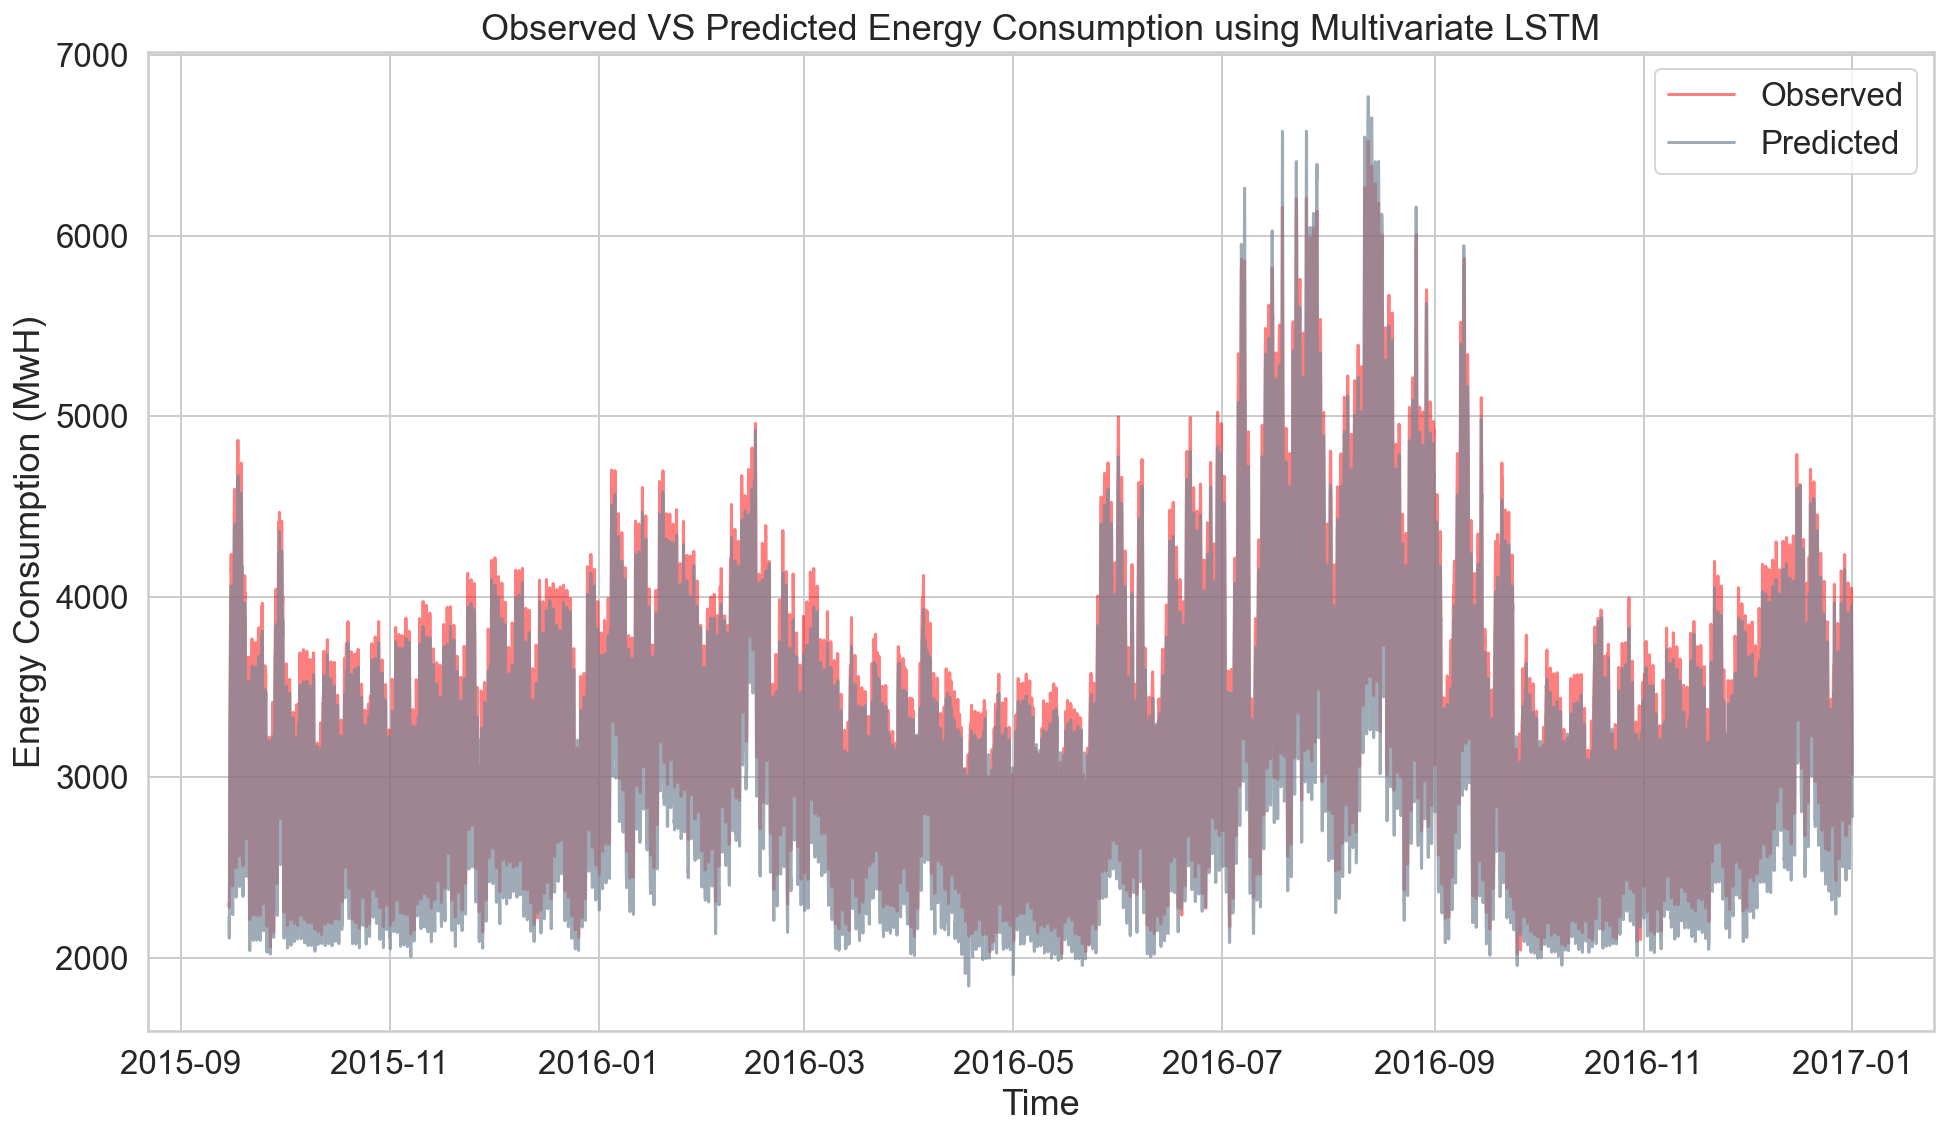

In [142]:
PlotPredictedTS(y_test_inv, LSTM_pred, model_name='Multivariate LSTM')

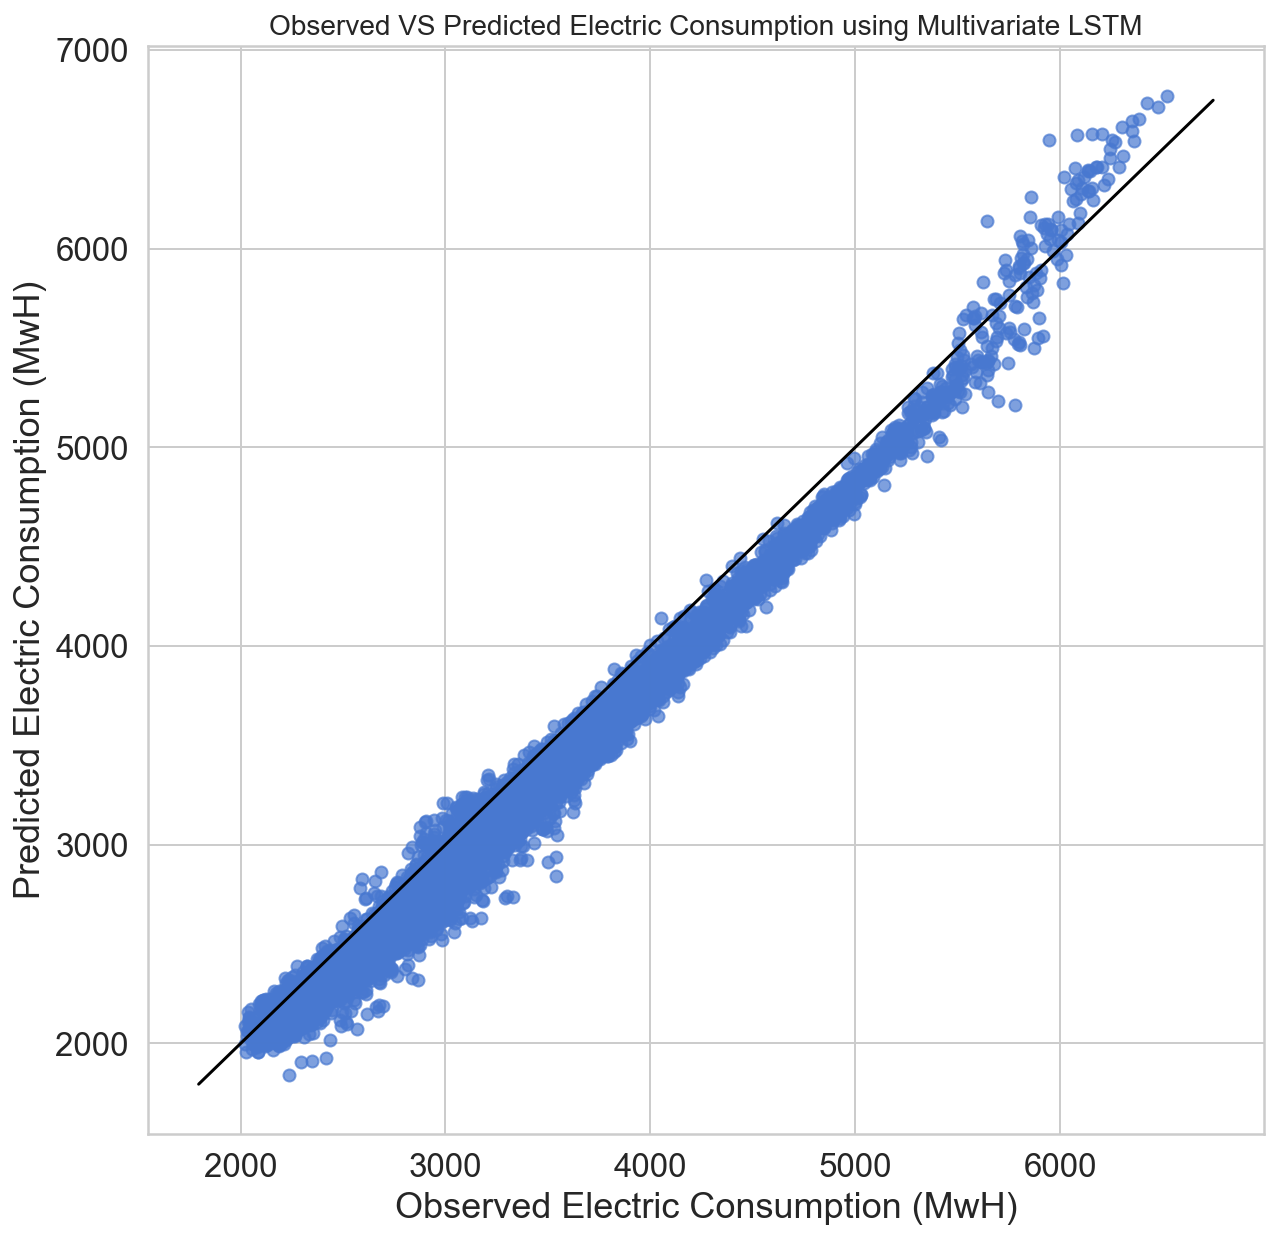

In [144]:
PredTrueReg(LSTM_pred,y_test_inv, model_name='Multivariate LSTM')

In [147]:
LSTM_pred_train = modelLSTM.predict(X_train)

3205/3205 [==============================] - 40s 13ms/step


In [161]:
y_train_inv = demand_transformer.inverse_transform(y_train.reshape(1, -1))
LSTM_pred_train = demand_transformer.inverse_transform(LSTM_pred_train)

In [162]:
y_train_inv = pd.DataFrame(y_train_inv[0], index=df.index[:(len(y_train))])
y_train_inv = pd.Series(y_train_inv[0])
y_train_inv

ts
2004-01-01 00:00:00    2970.0
2004-01-01 01:00:00    2854.0
2004-01-01 02:00:00    2787.0
2004-01-01 03:00:00    2767.0
2004-01-01 04:00:00    2806.0
                        ...  
2015-09-12 21:00:00    3475.0
2015-09-12 22:00:00    3150.0
2015-09-12 23:00:00    2829.0
2015-09-13 00:00:00    2587.0
2015-09-13 01:00:00    2439.0
Name: 0, Length: 102554, dtype: float64

In [164]:
LSTM_pred_train = pd.DataFrame(LSTM_pred_train, index=df.index[:len(y_train)])
LSTM_pred_train = pd.Series(LSTM_pred_train[0])
LSTM_pred_train

ts
2004-01-01 00:00:00    2779.131592
2004-01-01 01:00:00    2677.306885
2004-01-01 02:00:00    2665.939209
2004-01-01 03:00:00    2560.687012
2004-01-01 04:00:00    2656.760742
                          ...     
2015-09-12 21:00:00    3465.793701
2015-09-12 22:00:00    3178.794922
2015-09-12 23:00:00    2901.569580
2015-09-13 00:00:00    2580.847412
2015-09-13 01:00:00    2297.164551
Name: 0, Length: 102554, dtype: float32

In [167]:
modelLSTM.save('LSTM_Model.h5')

# Comparing the LSTM Model with the other Models

In [174]:
import pickle

with open('dict_error.txt', 'rb') as openfile:
    lstm_error = pickle.load(openfile)
openfile.close()

In [177]:
error_metrics(LSTM_pred, y_test_inv, model_name='Multivariate LSTM', test=True)

Error metrics for Multivariate LSTM 

Root Mean Squared Error (RMSE): 176.151
Mean Absolute Error (MAE): 159.469
Mean Absolute Percentage Error (MAPE): 4.865 %
Variance Score (R2): 0.943


In [178]:
error_metrics(LSTM_pred_train, y_train_inv, model_name='Multivariate LSTM', test=False)

Error metrics for Multivariate LSTM 

Root Mean Squared Error (RMSE): 191.914
Mean Absolute Error (MAE): 179.448
Mean Absolute Percentage Error (MAPE): 5.028 %
Variance Score (R2): 0.942


In [181]:
table = pd.DataFrame.from_dict(lstm_error)
pivot = table.pivot_table(index='model', columns='train_test', aggfunc='min').sort_values(('MAPE', 'test'), ascending=True)
pivot = (pivot.sort_index(axis=1, level=1, ascending=False).sort_index(axis=1, level=[0], sort_remaining=False)).round(3)
pivot.style.highlight_min(['MAPE', 'MAE', 'RMSE'], axis=0).highlight_max(['R2'], axis=0).highlight_null(null_color='grey')

<Figure size 648x1152 with 0 Axes>

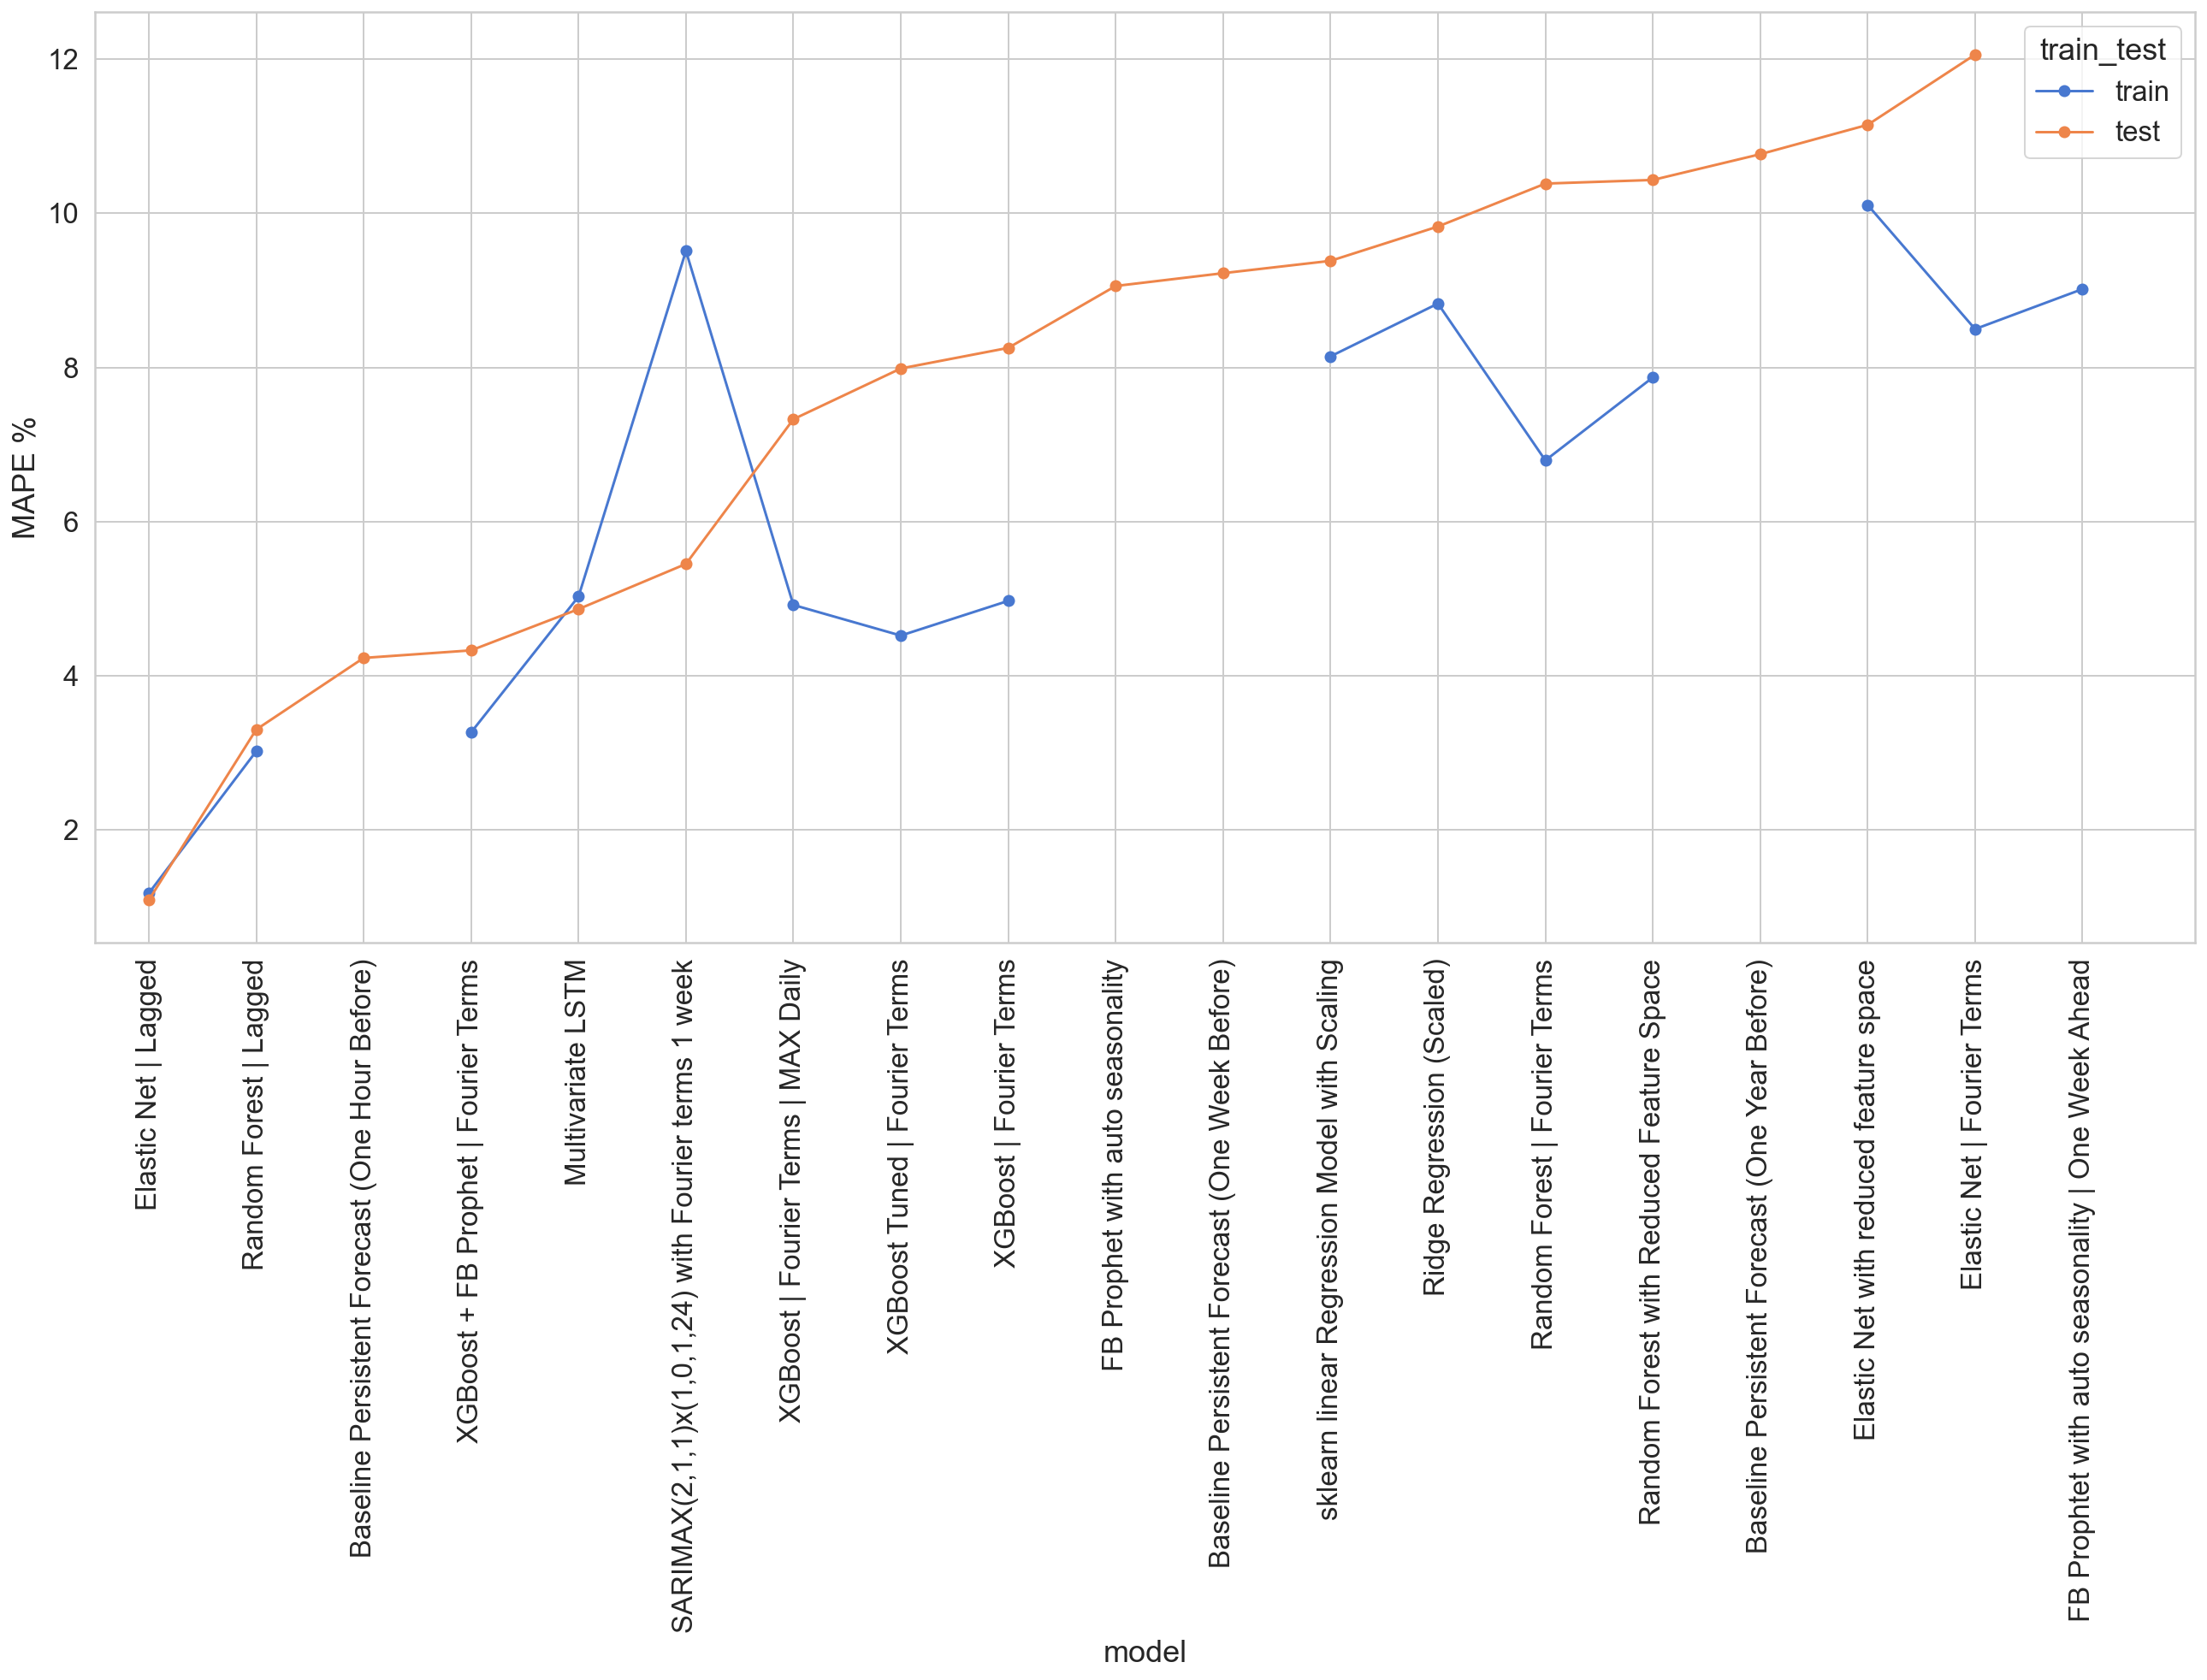

In [182]:
p = plt.figure(figsize=(9,16))
p = pivot['MAPE'].plot(style='o-')
p = plt.xticks(ticks = range(0,len(pivot)),labels = pivot.index.values,  rotation=90)
p = plt.xlim([-0.5,len(pivot)+0.05])
p = plt.ylabel('MAPE %')